In [1]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%
from IPython import get_ipython


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # dataviz
import seaborn as sns # dataviz
from pandas.plotting import scatter_matrix

Rental= pd.read_csv("/home/feras/ApartmentRentalOffersInBerlin/dataset/immo_data.csv")

get_ipython().run_line_magic('matplotlib', 'inline')


In [4]:
Rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268849 entries, 0 to 268848
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268849 non-null  object 
 1   serviceCharge             261936 non-null  float64
 2   heatingType               224005 non-null  object 
 3   telekomTvOffer            236250 non-null  object 
 4   telekomHybridUploadSpeed  45041 non-null   float64
 5   newlyConst                268849 non-null  bool   
 6   balcony                   268849 non-null  bool   
 7   picturecount              268849 non-null  int64  
 8   pricetrend                267029 non-null  float64
 9   telekomUploadSpeed        235509 non-null  float64
 10  totalRent                 228347 non-null  float64
 11  yearConstructed           211813 non-null  float64
 12  scoutId                   268849 non-null  int64  
 13  noParkSpaces              93037 non-null   f

In [5]:
Rental.describe() #shows a summary of the numerical attributes


,serviceCharge,telekomHybridUploadSpeed,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,yearConstructedRange,...,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,livingSpaceRange,heatingCosts,lastRefurbish,electricityBasePrice,electricityKwhPrice
count,261936.000000,45041.0,268849.000000,267029.000000,235509.000000,2.283470e+05,211813.000000,2.688490e+05,93037.000000,211813.000000,...,268849.000000,162328.000000,217528.000000,171091.000000,268849.000000,268849.000000,85518.000000,80696.000000,46787.000000,46787.000000
mean,151.208704,10.0,9.791876,3.387949,28.804855,9.012967e+02,1966.395797,1.069697e+08,1.327128,3.714597,...,2.641872,114.734794,2.122357,3.572421,2.571477,3.070664,77.009232,2013.908942,89.112362,0.199762
std,308.308381,0.0,6.406189,1.964906,16.336629,3.323732e+04,47.052530,1.250095e+07,8.360360,2.738214,...,2.665693,61.636095,3.634880,6.376146,0.937624,1.407012,147.726834,10.960901,5.397662,0.009662
min,0.000000,10.0,0.000000,-12.330000,1.000000,0.000000e+00,1000.000000,2.887174e+07,0.000000,1.000000,...,1.000000,0.100000,-1.000000,0.000000,1.000000,1.000000,0.000000,1015.000000,71.430000,0.170500
25%,95.000000,10.0,6.000000,2.000000,10.000000,4.699950e+02,1950.000000,1.066910e+08,1.000000,1.000000,...,2.000000,79.000000,1.000000,2.000000,2.000000,2.000000,54.000000,2012.000000,90.760000,0.191500
50%,135.000000,10.0,9.000000,3.390000,40.000000,6.500000e+02,1973.000000,1.111584e+08,1.000000,3.000000,...,3.000000,107.000000,2.000000,3.000000,3.000000,3.000000,70.000000,2017.000000,90.760000,0.198500
75%,190.000000,10.0,13.000000,4.570000,40.000000,9.850000e+02,1996.000000,1.137688e+08,1.000000,5.000000,...,3.000000,140.300000,3.000000,4.000000,3.000000,4.000000,90.000000,2019.000000,90.760000,0.205500
max,146118.000000,10.0,121.000000,14.920000,100.000000,1.575154e+07,2090.000000,1.157117e+08,2241.000000,9.000000,...,999.990000,1996.000000,999.000000,999.000000,5.000000,7.000000,12613.000000,2919.000000,90.760000,0.227600


In [6]:
Berlin=Rental.loc[Rental["regio2"]=='Berlin']
print(Berlin)


        regio1  serviceCharge                     heatingType telekomTvOffer  \
19      Berlin         250.00                   floor_heating  ONE_YEAR_FREE   
48      Berlin         125.00                district_heating  ONE_YEAR_FREE   
85      Berlin         230.00                     gas_heating  ONE_YEAR_FREE   
104     Berlin         105.00                 central_heating  ONE_YEAR_FREE   
151     Berlin         206.00                 central_heating  ONE_YEAR_FREE   
...        ...            ...                             ...            ...   
268729  Berlin         100.00                 central_heating  ONE_YEAR_FREE   
268800  Berlin         350.00                 central_heating  ONE_YEAR_FREE   
268831  Berlin          80.04  self_contained_central_heating  ONE_YEAR_FREE   
268834  Berlin         324.47                 central_heating  ONE_YEAR_FREE   
268848  Berlin         233.08                 central_heating  ONE_YEAR_FREE   

        telekomHybridUploadSpeed  newly

In [7]:
corr_matrix = Berlin.corr()
corr_matrix["totalRent"].sort_values(ascending=False)


totalRent                   1.000000
baseRent                    0.876431
livingSpace                 0.747748
serviceCharge               0.701983
baseRentRange               0.630741
livingSpaceRange            0.629388
noRoomsRange                0.517548
heatingCosts                0.439351
noRooms                     0.415801
picturecount                0.297007
hasKitchen                  0.220137
lift                        0.197116
yearConstructedRange        0.179634
balcony                     0.145889
cellar                      0.105148
newlyConst                  0.097460
garden                      0.097199
floor                       0.068278
yearConstructed             0.066111
numberOfFloors              0.041601
lastRefurbish               0.034407
pricetrend                  0.015857
electricityBasePrice        0.006113
electricityKwhPrice        -0.006113
scoutId                    -0.025795
noParkSpaces               -0.038506
telekomUploadSpeed         -0.062011
t

In [8]:
Berlin.corr()["baseRent"].sort_values(ascending=False)


baseRent                    1.000000
totalRent                   0.876431
livingSpace                 0.830674
serviceCharge               0.734748
baseRentRange               0.731546
livingSpaceRange            0.704301
noRoomsRange                0.583292
heatingCosts                0.571913
noRooms                     0.475541
picturecount                0.335906
hasKitchen                  0.266178
lift                        0.225659
yearConstructedRange        0.177993
balcony                     0.170298
cellar                      0.122512
newlyConst                  0.118501
garden                      0.106234
floor                       0.072635
yearConstructed             0.056400
numberOfFloors              0.051537
lastRefurbish               0.046471
pricetrend                  0.014995
electricityBasePrice        0.006246
scoutId                    -0.005969
electricityKwhPrice        -0.006246
noParkSpaces               -0.043217
telekomUploadSpeed         -0.079268
t

<function pandas.plotting._misc.scatter_matrix(frame, alpha=0.5, figsize=None, ax=None, grid=False, diagonal='hist', marker='.', density_kwds=None, hist_kwds=None, range_padding=0.05, **kwargs)>

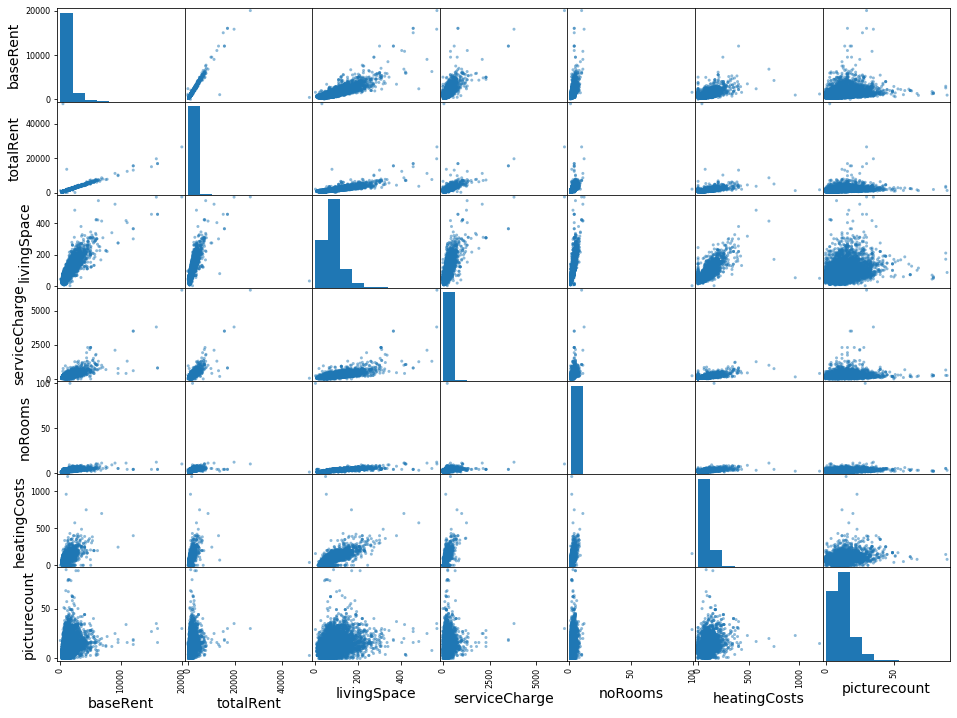

In [9]:
attributes = ["baseRent","totalRent","livingSpace", "serviceCharge", "noRooms","heatingCosts","picturecount"]
scatter_matrix(Berlin[attributes], figsize=(16, 12))
scatter_matrix


In [10]:
Berlin["totalRent"].describe()


count     9743.000000
mean      1386.728040
std       1133.166905
min          0.000000
25%        792.055000
50%       1124.330000
75%       1685.000000
max      51570.000000
Name: totalRent, dtype: float64

/home/feras/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


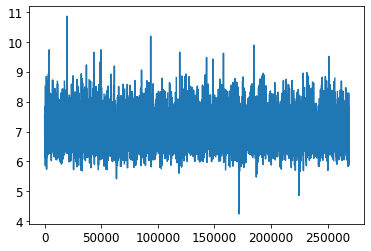

In [11]:
plt.plot(np.log(Berlin["totalRent"]))


Text(0, 0.5, 'Count')

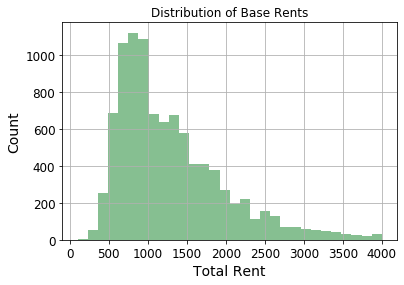

In [12]:
Berlin['totalRent'].hist(bins=30, range=(100,4000), grid=True, color='#86bf91')
plt.title('Distribution of Base Rents')
plt.xlabel('Total Rent')
plt.ylabel('Count')


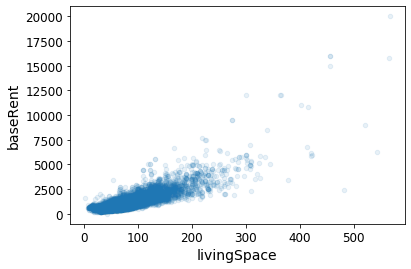

In [13]:
Berlin.plot(kind="scatter", x="livingSpace", y="baseRent", alpha=0.1)


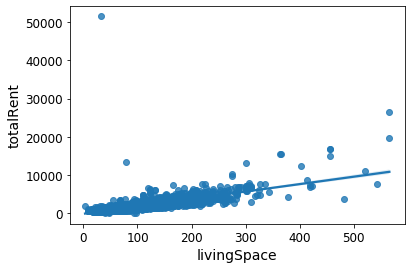

In [14]:
sns.regplot(x='livingSpace', y='totalRent', data=Berlin)

Text(0, 0.5, 'totalRent')

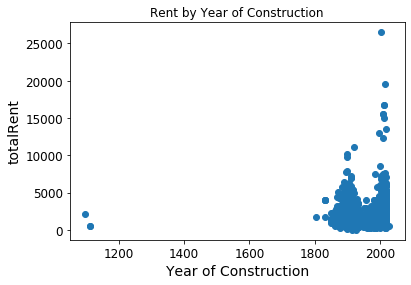

In [63]:
plt.scatter(x='yearConstructed', y='totalRent', data=Berlin)
plt.title('Rent by Year of Construction')
plt.xlabel('Year of Construction')
plt.ylabel('totalRent')

In [64]:
m=Berlin.groupby(['regio3'])['baseRent'].mean()
m.sort_values()


regio3
Marzahn_Marzahn                           500.651438
Hellersdorf_Hellersdorf                   546.908897
Haselhorst_Spandau                        608.990000
Staaken_Spandau                           610.255091
Neu_Hohenschönhausen_Hohenschönhausen     612.841250
                                            ...     
Rummelsburg_Lichtenberg                  1776.020000
Dahlem_Zehlendorf                        1808.883448
Gatow_Spandau                            1825.090000
Mitte_Mitte                              1896.462699
Grunewald_Wilmersdorf                    2449.683763
Name: baseRent, Length: 79, dtype: float64

In [15]:
#droping initial columns
cols_to_drop = ["telekomHybridUploadSpeed", "picturecount", "telekomUploadSpeed",
                "geo_bln", "houseNumber", "geo_krs", "geo_plz", "regio3", "description",
                "facilities"]

Berlin = Berlin.drop(cols_to_drop, axis=1)

#Columns with several NULL entries are dropped too.

Berlin.isna().sum()

#filter columns for berlin
#Berlin = Berlin[Berlin["regio2"]=="Berlin"]

#sorting and re_indexing regarding to the price
Berlin = Berlin.sort_values(by=['totalRent'])
Berlin = Berlin.reset_index(drop=True)

#filter some columns between specific amount of values
Berlin = Berlin.query("totalRent >= 100").query("totalRent<10000")
Berlin = Berlin.query("baseRent >= 100").query("baseRent<10000")
Berlin = Berlin.query("livingSpace >= 10").query("livingSpace<400")
Berlin = Berlin.query("noRooms >= 0").query("noRooms<15")




# Replacing columns with f/t with 0/1
Berlin.replace({False: 0, True: 1}, inplace=True)


In [16]:
#make a single binary variable to indicate if the apartment is refurbished/new
Berlin['refurbished'] = (Berlin.condition == 'refurbished') | (Berlin.condition == 'first_time_use') | (Berlin.condition == 'mint_condition') | (Berlin.condition == 'fully_renovated') | (Berlin.condition == 'first_time_use_after_refurbishment')

#make a binary variable to indicate if the rental property has good interior
Berlin['greatInterior'] = (Berlin.interiorQual == 'sophisticated') | (Berlin.interiorQual == 'luxury')

#make a binary variable to indicated if the rental property has good heating
Berlin['goodHeating'] = (Berlin.heatingType == 'central_heating') | (Berlin.heatingType == 'floor_heating') | (Berlin.heatingType == 'self_contained_central_heating')


#transform totalRent into log(totalRent) to get a better distribution + better interpretive quality
Berlin['logRent'] = np.log(Berlin['totalRent'])


In [17]:
y_var = ['logRent']
X_var = ['balcony', 'hasKitchen', 'cellar', 'livingSpace', 'noRooms', 'garden',
         'refurbished', 'greatInterior', 'newlyConst', 'lift']

#y = Berlin[y_var].iloc[:,0].values
#X = Berlin[X_var].iloc[:,0].values
y = Berlin[y_var].values
X = Berlin[X_var].values

#print(X)
#print(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=0)


In [18]:
#LINEAR REGRESSION
from sklearn.linear_model import LinearRegression
from sklearn import metrics

def linearregression(xtrain, ytrain, xtest, ytest):
    linreg = LinearRegression()
    linreg.fit(xtrain, ytrain)
    y_pred = linreg.predict(xtest)
    print('MAE:', metrics.mean_absolute_error(ytest, y_pred))
    print('MSE:', metrics.mean_squared_error(ytest, y_pred))

linearregression(X_train, y_train, X_test, y_test)


MAE: 0.19969525908855787
MSE: 0.06536390275539797


In [20]:

#RANDOM FOREST
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

#minsamleaf:10, maxfeat: 10, maxdepth: 24 
#number of trees by default is 100 
#creterion by default is mse 
def randomforestreg(msl, mf, md, xtrain, ytrain, xtest, ytest):
    rfr_best = RandomForestRegressor(n_estimators=70, random_state=1111,
                                     max_depth=md, max_features=mf, min_samples_leaf=msl)
    rfr_best.fit(xtrain,ytrain)
    y_pred_rfr = rfr_best.predict(xtest)
    print('MAE:', metrics.mean_absolute_error(ytest, y_pred_rfr))
    print('MSE:', metrics.mean_squared_error(ytest, y_pred_rfr))
    
randomforestreg(10, 10, 24, X_train, y_train, X_test, y_test)


/home/feras/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


MAE: 0.17604002893383908
MSE: 0.05221068113044676


In [70]:
#GRADIENT BOOSTING
from sklearn.ensemble import GradientBoostingRegressor

#maxdepth: , minsamleaf: , n: , maxfeat: , lr: 0.07
def gradientboostingmachine(md, msl, n, mf, lr, xtrain, ytrain, xtest, ytest):
    gbm_best = GradientBoostingRegressor(n_estimators=n, random_state=1111,
                                         max_depth=md, max_features=mf, 
                                         min_samples_leaf=msl, learning_rate=lr
                                         )
    gbm_best.fit(xtrain, ytrain)
    y_pred_gbm = gbm_best.predict(xtest)
    print('MAE:', metrics.mean_absolute_error(ytest, y_pred_gbm))
    print('MSE:', metrics.mean_squared_error(ytest, y_pred_gbm))
    
gradientboostingmachine(16, 117, 73, 10, 0.07, X_train, y_train, X_test, y_test)


/home/feras/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 0.17734847502986426
MSE: 0.05254156594990447


In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
lin_reg = LinearRegression()


scores = cross_val_score(lin_reg, X_train, y_train,
                        scoring="neg_mean_squared_error", cv=10)

# find root mean squared error, scores is an array of negative numbers
rmse_scores = np.sqrt(-scores)

print("Mean:\t\t ", rmse_scores.mean(), "\nStandard Deviation:", rmse_scores.std())


Mean:		  0.25296158665705015 
Standard Deviation: 0.008440515555231154


## more models

In [72]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

y_var = ['logRent']
X_var = ['balcony', 'hasKitchen', 'cellar', 'livingSpace', 'noRooms', 'garden',
         'refurbished', 'greatInterior', 'newlyConst', 'lift']

y = Berlin[y_var].iloc[:,0].values
X = Berlin[X_var].iloc[:,3].values

#print(X)
#print(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=0)


In [73]:
Berlin[X_var]["livingSpace"]

3        39.55
4        18.56
5        24.31
6        30.33
7        26.52
         ...  
9723    335.00
9725    326.35
9726    220.00
9727    307.00
9729    274.00
Name: livingSpace, Length: 9715, dtype: float64

In [74]:
Berlin[y_var].head()

,logRent
3,4.867534
4,5.423848
5,5.480597
6,5.598200
7,5.607272


In [75]:

from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()
linear_regressor.fit(np.array(X_train.reshape(-1, 1)), y_train.reshape(-1, 1))

y_predict = linear_regressor.predict(X_test.reshape(-1, 1))

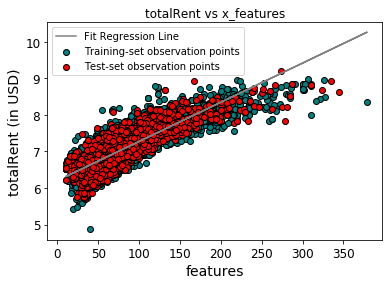

In [76]:
# Plot points and fit line for training data
plt.scatter(X_train, y_train, color='teal', edgecolors='black', label='Training-set observation points')
plt.plot(X_train.reshape(-1, 1), linear_regressor.predict(X_train.reshape(-1, 1)), color='grey', label='Fit Regression Line')
plt.title('totalRent vs x_features')
plt.xlabel('features')
plt.ylabel('totalRent (in USD)')

# plot scatter points and line for test data
plt.scatter(X_test, y_test, color='red', edgecolors='black', label='Test-set observation points')
plt.legend()
plt.show()

## Polynomial Regression

In [77]:
from sklearn.preprocessing import PolynomialFeatures

y_var = ['logRent']
X_var = ['balcony', 'hasKitchen', 'cellar', 'livingSpace', 'noRooms', 'garden',
         'refurbished', 'greatInterior', 'newlyConst', 'lift']

y = Berlin[y_var].iloc[:,0].values
X = Berlin[X_var].iloc[:,3:4].values



In [78]:
poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(X)

In [79]:
# linear regression model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X, y)

# polynomial regression model
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_poly, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

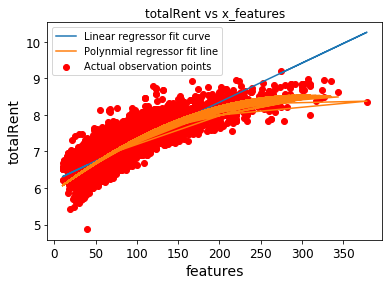

In [80]:
plt.scatter(X, y, color='red', label='Actual observation points')
plt.plot(X, linear_reg_model.predict(X), label='Linear regressor fit curve')
plt.plot(X, poly_reg_model.predict(poly_reg.fit_transform(X)), label='Polynmial regressor fit line')
plt.title('totalRent vs x_features')
plt.xlabel('features')
plt.ylabel('totalRent')

plt.legend()
plt.show()

## Simple Vector Regression

In [81]:
from sklearn.svm import SVR

scale_X = StandardScaler()
scale_y = StandardScaler()

X = scale_X.fit_transform(X)
y = scale_y.fit_transform(y.reshape(-1, 1))

In [82]:
svr_regressor = SVR(kernel='rbf', gamma='auto')
svr_regressor.fit(X, y)

/home/feras/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

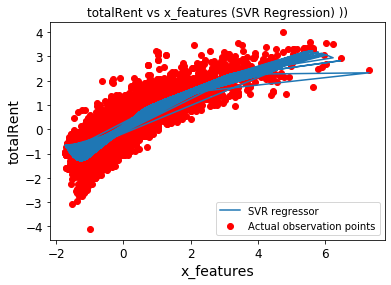

In [83]:
plt.scatter(X, y, color='red', label='Actual observation points')
plt.plot(X, svr_regressor.predict(X), label='SVR regressor')
plt.title('totalRent vs x_features (SVR Regression) ))')
plt.xlabel('x_features')
plt.ylabel('totalRent')

plt.legend()
plt.show()

## Decision Tree - Regression

In [84]:
from sklearn.tree import DecisionTreeRegressor
tree_regressor = DecisionTreeRegressor(random_state = 0)
tree_regressor.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

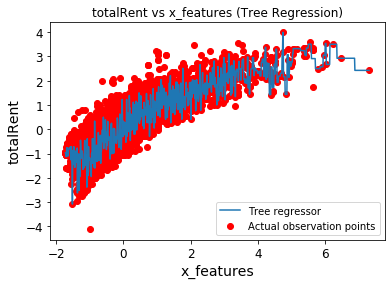

In [85]:
X_grid = np.arange(min(X), max(X), 0.01)
X_grid = X_grid.reshape(len(X_grid), 1)

plt.scatter(X, y, color='red', label='Actual observation points')
plt.plot(X_grid, tree_regressor.predict(X_grid), label='Tree regressor')
plt.title('totalRent vs x_features (Tree Regression)')
plt.xlabel('x_features')
plt.ylabel('totalRent')

plt.legend()
plt.show()

## Random Forest Regression

In [86]:
from sklearn.ensemble import RandomForestRegressor
forest_regressor = RandomForestRegressor(n_estimators = 300, random_state = 0)
forest_regressor.fit(X, y)

/home/feras/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

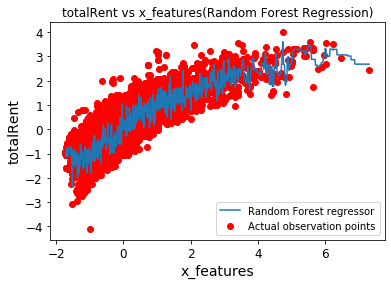

In [87]:
X_grid = np.arange(min(X), max(X), 0.01)
X_grid = X_grid.reshape(len(X_grid), 1)

plt.scatter(X, y, color='red', label='Actual observation points')
plt.plot(X_grid, forest_regressor.predict(X_grid), label='Random Forest regressor')
plt.title('totalRent vs x_features(Random Forest Regression)')
plt.xlabel('x_features')
plt.ylabel('totalRent')

plt.legend()
plt.show()